In [7]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, InputLayer,Conv2D, GlobalAveragePooling2D,MaxPool2D, Dropout, Flatten, Dense,MaxPooling2D, BatchNormalization,Resizing, Rescaling, Layer
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast, RandomZoom, GaussianNoise
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Add



In [8]:
import tensorflow_probability as tfp


In [3]:
!unzip TeethDataSet.zip -d /content/


Streaming output truncated to the last 5000 lines.

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_101_0_8008.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_102_0_9725.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_102_0_9936.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_104.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_104_0_40.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_105_0_1905.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_105_0_6014.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_106_0_2133.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_106_0_5505.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_107_0_1494.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testing/CoS/b_107_0_3779.jpg  

  inflating: /content/Teeth DataSet/Teeth_Dataset/Testi

In [9]:
train_directory="/kaggle/input/dataset/Teeth DataSet/Teeth_Dataset/Training"
validation_directory="/kaggle/input/dataset/Teeth DataSet/Teeth_Dataset/Validation"
test_directory="/kaggle/input/dataset/Teeth DataSet/Teeth_Dataset/Testing"

CLASS_NAMES=['CaS','CoS','Gum','MC','OC','OLP','OT']

CONFIGURATION= {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE":0.001,
    "N_EPOCHS":20,
    "DROPOUT_RATE":0.2,
    "REGULARIZATION_RATE":0.01,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":100,
    "N_DENSE_2":10,
    "NUM_CLASSES":7,
    "CLASS_NAMES":['CaS','CoS','Gum','MC','OC','OLP','OT']

}

In [10]:
train_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical', # ex: 0,0,1 called one-hot encoding
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(256, 256),
    shuffle=True,
    seed=99, #Spicified it to alweys same shuffling
    validation_split=None,

)

Found 3087 files belonging to 7 classes.


In [11]:

validation_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical', # ex: 0,0,1 called one-hot encoding
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99, #Spicified it to alweys same shuffling

)

Found 1028 files belonging to 7 classes.


In [12]:
test_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical', # ex: (0,0,1) called one-hot encoding, many traditional neural network architectures are designed to work with one-hot encoded vectors.
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99, #Spicified it to alweys same shuffling

)

Found 1028 files belonging to 7 classes.


In [13]:
augment_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation((-0.025, 0.025)),
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),

])

def augment_layer(image,label):
    return augment_layers(image,training=True),label

In [14]:
training_dataset=(
train_dataset
.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
.prefetch(tf.data.AUTOTUNE)
)

val_datset=(
validation_dataset

.prefetch(tf.data.AUTOTUNE)
)
testing_datset=(
test_dataset
.prefetch(tf.data.AUTOTUNE)
)


In [15]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

backbone.trainable = False


pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       179,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,854,610 (68.11 MB)

 Trainable params: 180,587 (705.42 KB)

 Non-trainable params: 17,674,023 (67.42 MB)

In [16]:
metrics=[CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]
loss_function=CategoricalCrossentropy(from_logits=False)

In [17]:
for layer in backbone.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Compile the model with a lower learning rate
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])


In [18]:
from sklearn.utils import class_weight
import numpy as np

# Assuming 'train_dataset' is already defined and has labels in 'label_mode=categorical'
labels = np.concatenate([y for x, y in train_dataset], axis=0)
labels = np.argmax(labels, axis=1)  # Convert one-hot encoded labels to class indices

# Calculate the class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Automatically adjust weights inversely proportional to class frequencies
    classes=np.unique(labels),  # All unique classes
    y=labels  # The labels for the dataset
)

# Convert to a dictionary to use with TensorFlow
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights: ", class_weights_dict)


Class weights:  {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [21]:
history = pretrained_model.fit(
    training_dataset,
    validation_data=val_datset,
    epochs=100,
    verbose=1,
    class_weight=class_weights_dict  # Apply the class weights here
# Add the early stopping callback here
)

Epoch 1/100


I0000 00:00:1724941882.607032     121 service.cc:145] XLA service 0x7c7f14024100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724941882.607099     121 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724941882.607104     121 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/97 ━━━━━━━━━━━━━━━━━━━━ 2:13:12 83s/step - accuracy: 0.0938 - loss: 2.5938

I0000 00:00:1724941942.312250     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 170s 900ms/step - accuracy: 0.1550 - loss: 2.3011 - val_accuracy: 0.2140 - val_loss: 1.8879
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.2361 - loss: 1.9997 - val_accuracy: 0.2850 - val_loss: 1.7743
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.2890 - loss: 1.8177 - val_accuracy: 0.3317 - val_loss: 1.6741
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 242ms/step - accuracy: 0.3151 - loss: 1.7390 - val_accuracy: 0.3813 - val_loss: 1.5917
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.3653 - loss: 1.6185 - val_accuracy: 0.4173 - val_loss: 1.5264
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.3883 - loss: 1.5669 - val_accuracy: 0.4407 - val_loss: 1.4632
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - accuracy: 0.4329 - loss: 1.4877 - val_accuracy: 0.4660 - val_loss: 1.4097
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.4320 - loss: 1.4691 - val_accurac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.8360 - loss: 0.5356 - val_accuracy: 0.8745 - val_loss: 0.4606
Epoch 64/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.8492 - loss: 0.5087 - val_accuracy: 0.8852 - val_loss: 0.4498
Epoch 65/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - accuracy: 0.8444 - loss: 0.5220 - val_accuracy: 0.8852 - val_loss: 0.4428
Epoch 66/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.8614 - loss: 0.4952 - val_accuracy: 0.8911 - val_loss: 0.4325
Epoch 67/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.8544 - loss: 0.4995 - val_accuracy: 0.8940 - val_loss: 0.4256
Epoch 68/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.8615 - loss: 0.4829 - val_accuracy: 0.8998 - val_loss: 0.4155
Epoch 69/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.8640 - loss: 0.4757 - val_accuracy: 0.9018 - val_loss: 0.4088
Epoch 70/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.8793 - loss: 0.4627 - val_a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - accuracy: 0.9334 - loss: 0.2927 - val_accuracy: 0.9630 - val_loss: 0.2316
Epoch 98/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.9357 - loss: 0.3070 - val_accuracy: 0.9640 - val_loss: 0.2266
Epoch 99/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.9402 - loss: 0.2766 - val_accuracy: 0.9669 - val_loss: 0.2210
Epoch 100/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.9343 - loss: 0.2916 - val_accuracy: 0.9660 - val_loss: 0.2145


In [16]:
import pickle

# Saving the model with pickle (not recommended for TensorFlow models)
with open('/kaggle/working/modelKFINAL2.pkl', 'wb') as f:
    pickle.dump(pretrained_model, f)


In [22]:
pretrained_model.save('model2.h5')


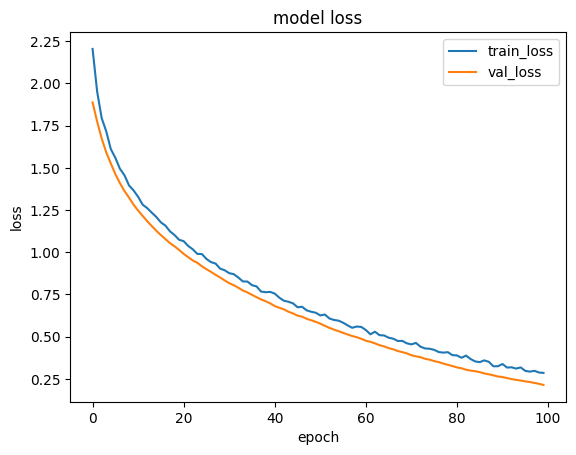

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

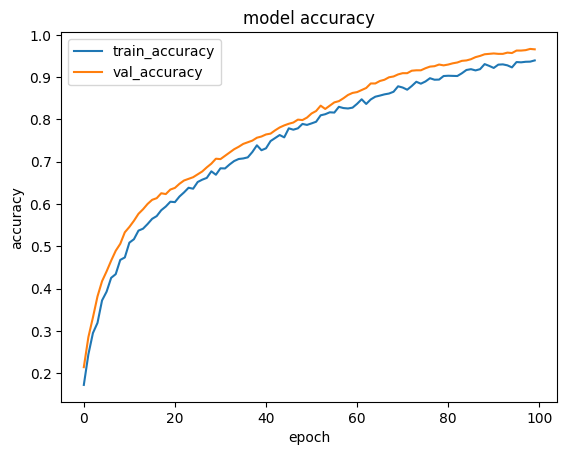

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [26]:
pretrained_model.evaluate(testing_datset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9679 - loss: 0.2047


[0.22093714773654938, 0.9630350470542908]

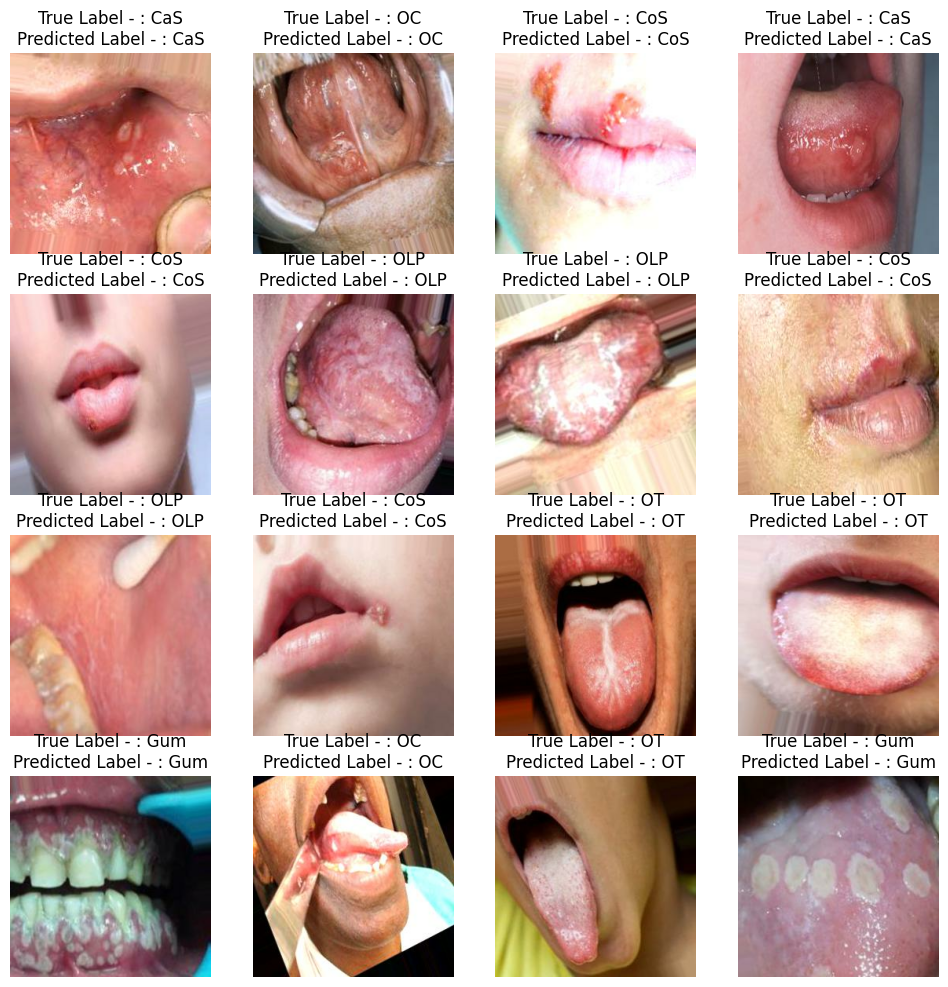

In [25]:
plt.figure(figsize = (12,12))

for images, labels in test_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)

        plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()] 
                  + "\n" + "Predicted Label - : " 
                  + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(pretrained_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
        plt.axis("off")
     

In [48]:
img_path="/kaggle/input/dataset/Teeth DataSet/Teeth_Dataset/Training/CoS/b_100.jpg"
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)
     


(1, 256, 256, 3)


In [49]:
preds = pretrained_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [52]:
preds

array([[1.9728015e-03, 9.5746952e-01, 2.5134314e-02, 6.9914111e-03,
        6.0441522e-03, 1.7987771e-04, 2.2079744e-03]], dtype=float32)

In [53]:
import numpy as np
np.argmax(preds[0])


1